# 2022/4/13
## 本代码旨在绘制降水的hovmoller图
## 使用数据为GPCP的气候态以及模式的气候态 CESM2控制实验和敏感性实验

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
import sys

sys.path.append("/home/sun/mycode/module/")
from module_sun import *

In [2]:
cesm_con        =  xr.open_dataset("/home/sun/data/cesm_control_prect_365_climate.nc")
cesm_noindian   =  xr.open_dataset("/home/sun/qomo-data/cesm_year_mean/replace_land/replace_indian.nc")
cesm_noinch     =  xr.open_dataset("/home/sun/qomo-data/cesm_year_mean/replace_land/replace_inch.nc")
cesm_1mall      =  xr.open_dataset("/home/sun/qomo-data/cesm_year_mean/topography_experiments/year_mean_cesm2_topo_all_1m_intel2_PRECT.nc")
cesm_1minch     =  xr.open_dataset("/home/sun/qomo-data/cesm_year_mean/topography_experiments/year_mean_cesm2_topo_indo_1m_intel_PRECT.nc")
cesm_notp       =  xr.open_dataset("/home/sun/qomo-data/cesm_year_mean/topography_experiments/year_mean_cesm2_topo_no_plateau_PRECT.nc")
gpcp_prect      =  xr.open_dataset("/home/sun/data/gpcp_prect_365_climate.nc")
trmm_prect      =  xr.open_dataset("/home/sun/data/trmm_prect_365_climate.nc")
time_slice      =  slice(100,200)
lat_slice       =  slice(12,20)
lon_slice       =  slice(55,145)
prect_con       =  cesm_con["prect"].sel(time=time_slice,lat = lat_slice,lon = lon_slice)  
prect_noindian  =  cesm_noindian["PRECT"].sel(time=time_slice,lat = lat_slice,lon = lon_slice)
prect_noinch    =  cesm_noinch["PRECT"].sel(time=time_slice,lat = lat_slice,lon = lon_slice)
prect_1mall     =  cesm_1mall["PRECT"].sel(time=time_slice,lat = lat_slice,lon = lon_slice)
prect_1minch    =  cesm_1minch["PRECT"].sel(time=time_slice,lat = lat_slice,lon = lon_slice)
prect_notp      =  cesm_notp["PRECT"].sel(time=time_slice,lat = lat_slice,lon = lon_slice)
prect_gpcp      =  gpcp_prect["prect"].sel(time=time_slice,lat = lat_slice,lon = lon_slice)
prect_trmm      =  trmm_prect["prect"].sel(time=time_slice,lat = lat_slice,lon = lon_slice)

### CESM输出单位是m/s
### GPCP已经是MM/DAY了
### TRMM是当日累积降水

In [3]:
#CESM输出单位是m/s
#  prect1.data  =  prect1.data*86400*1000

#GPCP已经是MM/DAY了
#TRMM是当日累积降水

### 读取并计算区域平均

In [4]:
np.set_printoptions(suppress=True)
#Compute weights and take weighted average over latitude dimension
weights1  =  np.cos(np.deg2rad(prect_con.lat.values))
weights3  =  np.cos(np.deg2rad(prect_gpcp.lat.values))
weights4  =  np.cos(np.deg2rad(prect_trmm.lat.values))

#  计算区域平均示例
#  avg_prect1  =  (prect_con*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)
#  avg_prect3  =  (prect_gpcp*weights3[None, :, None]).sum(dim='lat')/np.sum(weights3)
#  avg_prect4  =  (prect_trmm*weights4[None, None, :]).sum(dim='lat')/np.sum(weights4)

#### 绘制图像

In [25]:
# 坐标轴设置
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('Blues', 28)
newcolors = viridis(np.linspace(0, 0.7, 14))
newcmp = ListedColormap(newcolors)
newcmp.set_under('white')
#newcmp.set_over('#0d35c7')

#levels
#clevs = np.arange(5,55,5)
clevs = np.arange(6,60,6)/24

# Tick labels
x_tick_labels = []
for xx in range(60,141,10):
    x_tick_labels.append(u''+str(xx)+"\N{DEGREE SIGN}E")

y_tick = [100,110,120,130,140,150,161,171,181,191,201]
y_label = ['11Apr','21Apr','1May','11May','21May','31May','11Jun','21Jun','1Jul','11Jul','21Jul']

## CESM2 CONTROL

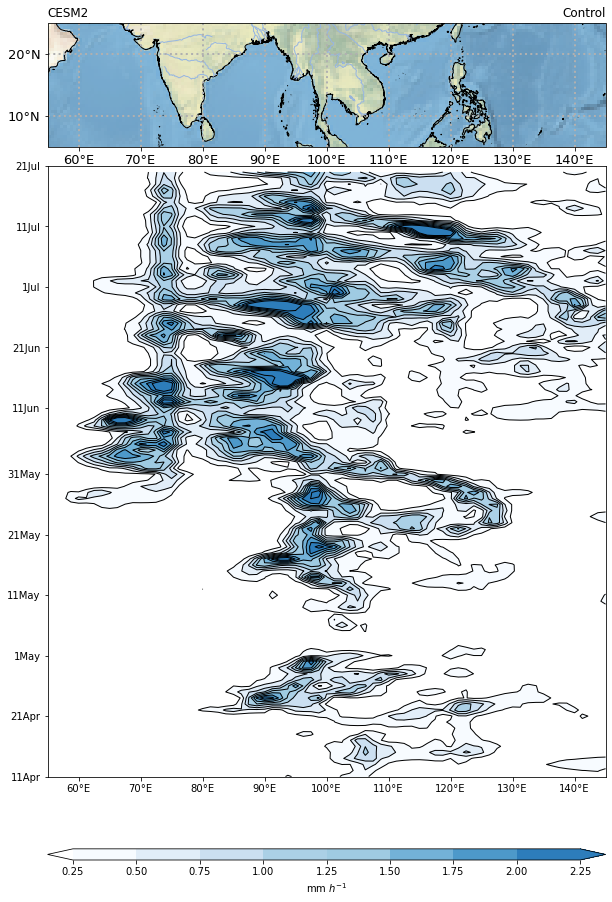

In [26]:
# Start figure
fig = plt.figure(figsize=(10, 17.5))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)


# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([55, 145, 5, 25], ccrs.PlateCarree())
ax1.set_yticks([10, 20])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'20\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(60,141,10))
ax1.set_xticklabels(x_tick_labels)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.05)
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES)
ax1.stock_img()

# Set some titles
plt.title('CESM2', loc='left')
plt.title('Control', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
cf   = ax2.contourf(prect_con.lon.values, prect_con.time.values, 1.1*(prect_con*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)*86400*1000/24, clevs, cmap=newcmp, extend='both')
cs   = ax2.contour(prect_con.lon.values,  prect_con.time.values, 1.1*(prect_con*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)*86400*1000/24, clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.09, aspect=50)
cbar.set_label('mm $h^{-1}$')

ax2.set_xticks(np.arange(60,141,10))
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(labelsize=10)

ax2.set_yticks(y_tick)
ax2.set_yticklabels(y_label)

plt.savefig("/home/sun/paint/cesm2_experiment_result/cesm_control_hovmoller_prect_220413.pdf",dpi=300)
plt.show()

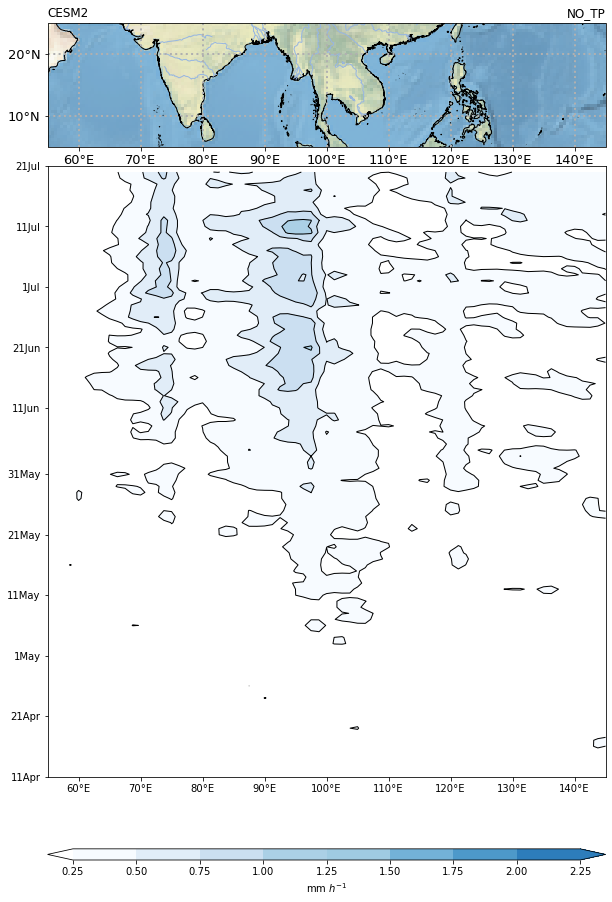

In [27]:
# Start figure
fig = plt.figure(figsize=(10, 17.5))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)


# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([55, 145, 5, 25], ccrs.PlateCarree())
ax1.set_yticks([10, 20])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'20\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(60,141,10))
ax1.set_xticklabels(x_tick_labels)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.05)
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES)
ax1.stock_img()

# Set some titles
plt.title('CESM2', loc='left')
plt.title('NO_TP', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
cf   = ax2.contourf(prect_con.lon.values, prect_con.time.values, (prect_notp*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)*86400*1000/24, clevs, cmap=newcmp, extend='both')
cs   = ax2.contour(prect_con.lon.values,  prect_con.time.values, (prect_notp*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)*86400*1000/24, clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.09, aspect=50)
cbar.set_label('mm $h^{-1}$')

ax2.set_xticks(np.arange(60,141,10))
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(labelsize=10)

ax2.set_yticks(y_tick)
ax2.set_yticklabels(y_label)

plt.savefig("/home/sun/paint/cesm2_experiment_result/cesm_notp_hovmoller_prect_220414.pdf",dpi=300)
plt.show()

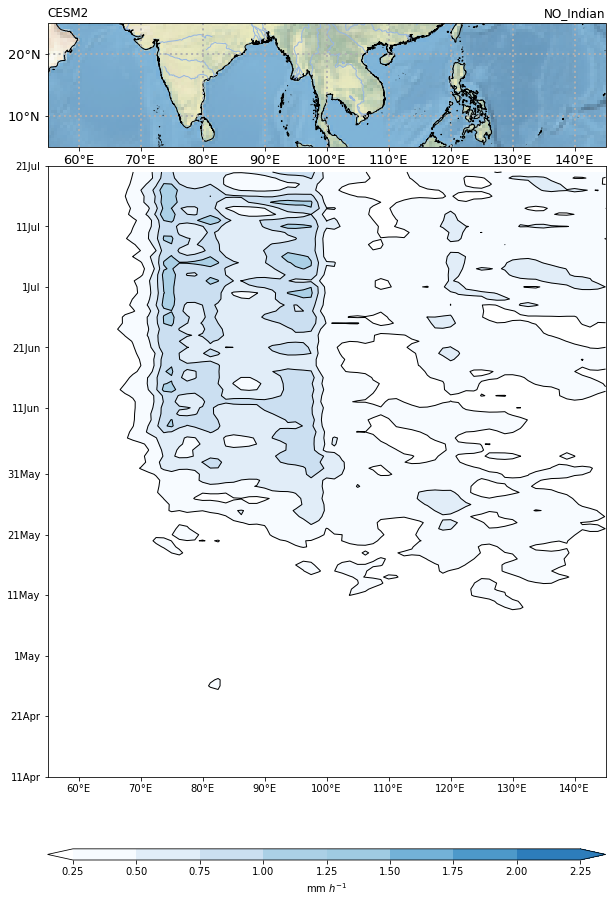

In [28]:
# Start figure
fig = plt.figure(figsize=(10, 17.5))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)


# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([55, 145, 5, 25], ccrs.PlateCarree())
ax1.set_yticks([10, 20])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'20\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(60,141,10))
ax1.set_xticklabels(x_tick_labels)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.05)
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES)
ax1.stock_img()

# Set some titles
plt.title('CESM2', loc='left')
plt.title('NO_Indian', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
cf   = ax2.contourf(prect_con.lon.values, prect_con.time.values, 0.9*(prect_noindian*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)*86400*1000/24, clevs, cmap=newcmp, extend='both')
cs   = ax2.contour(prect_con.lon.values,  prect_con.time.values, 0.9*(prect_noindian*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)*86400*1000/24, clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.09, aspect=50)
cbar.set_label('mm $h^{-1}$')

ax2.set_xticks(np.arange(60,141,10))
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(labelsize=10)

ax2.set_yticks(y_tick)
ax2.set_yticklabels(y_label)

plt.savefig("/home/sun/paint/cesm2_experiment_result/cesm_noindian_hovmoller_prect_220413.pdf",dpi=300)
plt.show()

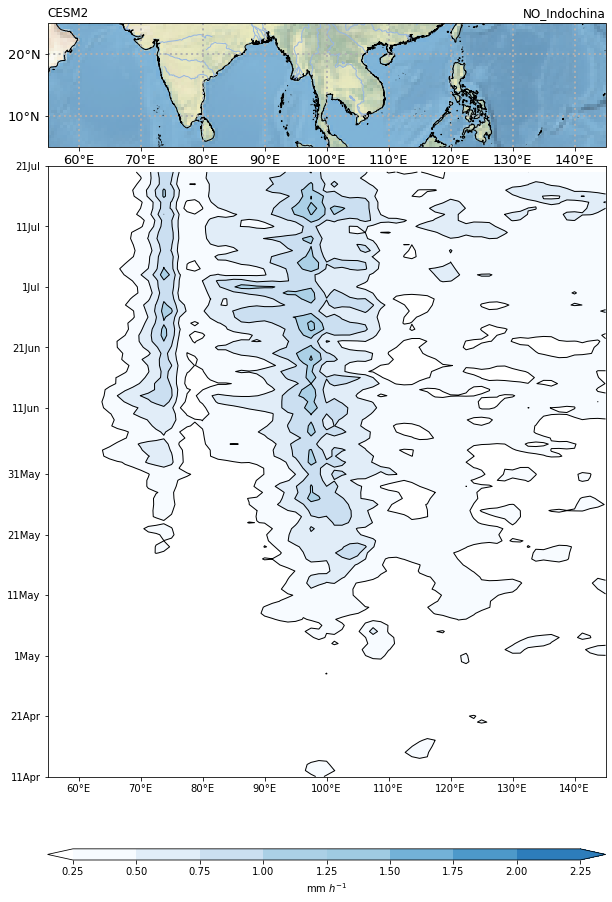

In [29]:
# Start figure
fig = plt.figure(figsize=(10, 17.5))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)


# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([55, 145, 5, 25], ccrs.PlateCarree())
ax1.set_yticks([10, 20])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'20\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(60,141,10))
ax1.set_xticklabels(x_tick_labels)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.05)
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES)
ax1.stock_img()

# Set some titles
plt.title('CESM2', loc='left')
plt.title('NO_Indochina', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
cf   = ax2.contourf(prect_con.lon.values, prect_con.time.values, (prect_noinch*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)*86400*1000/24, clevs, cmap=newcmp, extend='both')
cs   = ax2.contour(prect_con.lon.values,  prect_con.time.values, (prect_noinch*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)*86400*1000/24, clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.09, aspect=50)
cbar.set_label('mm $h^{-1}$')

ax2.set_xticks(np.arange(60,141,10))
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(labelsize=10)

ax2.set_yticks(y_tick)
ax2.set_yticklabels(y_label)

plt.savefig("/home/sun/paint/cesm2_experiment_result/cesm_noindochina_hovmoller_prect_220413.pdf",dpi=300)
plt.show()

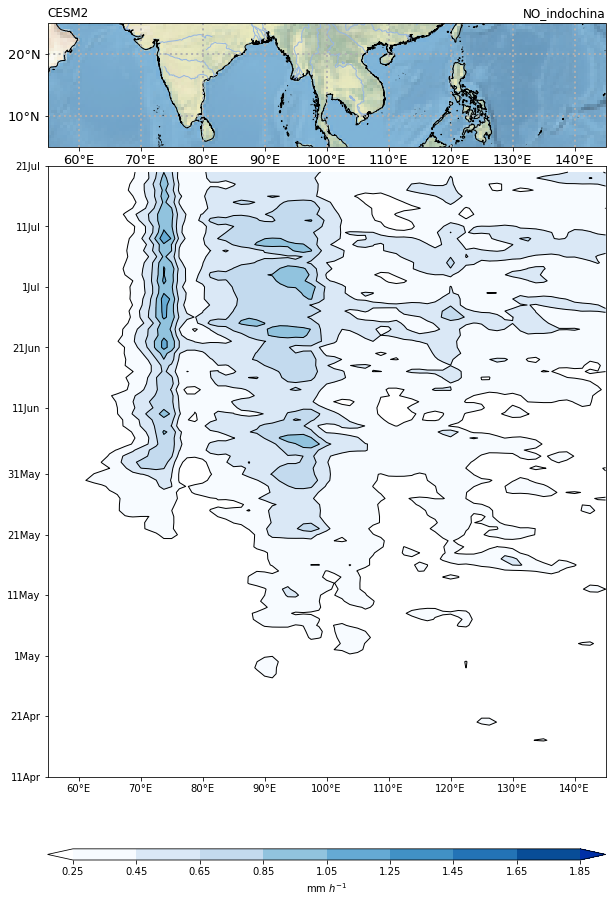

In [39]:
# Start figure
fig = plt.figure(figsize=(10, 17.5))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)


# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([55, 145, 5, 25], ccrs.PlateCarree())
ax1.set_yticks([10, 20])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'20\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(60,141,10))
ax1.set_xticklabels(x_tick_labels)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.05)
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES)
ax1.stock_img()

# Set some titles
plt.title('CESM2', loc='left')
plt.title('NO_indochina', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
cf   = ax2.contourf(prect_con.lon.values, prect_con.time.values, (prect_1minch*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)*86400*1000/24, clevs, cmap=newcmp, extend='both')
cs   = ax2.contour(prect_con.lon.values,  prect_con.time.values, (prect_1minch*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)*86400*1000/24, clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.09, aspect=50)
cbar.set_label('mm $h^{-1}$')

ax2.set_xticks(np.arange(60,141,10))
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(labelsize=10)

ax2.set_yticks(y_tick)
ax2.set_yticklabels(y_label)

plt.savefig("/home/sun/paint/cesm2_experiment_result/cesm_noindochina_hovmoller_prect_220413.pdf",dpi=300)
plt.show()

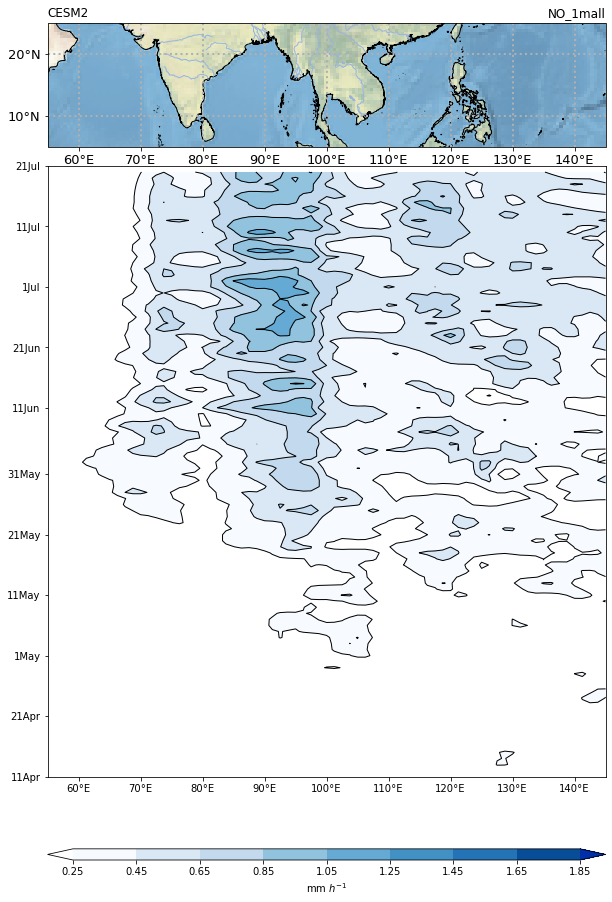

In [37]:
# Start figure
fig = plt.figure(figsize=(10, 17.5))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)


# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([55, 145, 5, 25], ccrs.PlateCarree())
ax1.set_yticks([10, 20])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'20\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(60,141,10))
ax1.set_xticklabels(x_tick_labels)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.05)
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES)
ax1.stock_img()

# Set some titles
plt.title('CESM2', loc='left')
plt.title('NO_1mall', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
cf   = ax2.contourf(prect_con.lon.values, prect_con.time.values, 1.1*(prect_1mall*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)*86400*1000/24, clevs, cmap=newcmp, extend='both')
cs   = ax2.contour(prect_con.lon.values,  prect_con.time.values, 1.1*(prect_1mall*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1)*86400*1000/24, clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.09, aspect=50)
cbar.set_label('mm $h^{-1}$')

ax2.set_xticks(np.arange(60,141,10))
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(labelsize=10)

ax2.set_yticks(y_tick)
ax2.set_yticklabels(y_label)

plt.savefig("/home/sun/paint/cesm2_experiment_result/cesm_1mall_hovmoller_prect_220413.pdf",dpi=300)
plt.show()

## TRMM

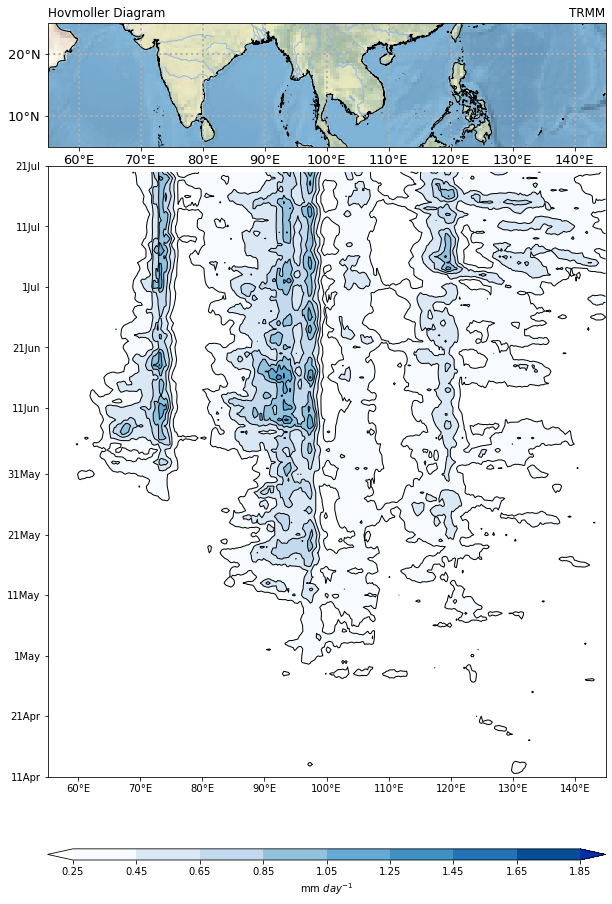

In [36]:
# 因为trmm和模式之间的差异，所以用的不是一个colormap
viridis = cm.get_cmap('Blues', 28)
newcolors = viridis(np.linspace(0, 0.9, 28))
newcmp = ListedColormap(newcolors)
newcmp.set_under('white')
newcmp.set_over('#002FA7')
#levels
clevs = np.arange(6,45,4.8)/24


# Start figure
fig = plt.figure(figsize=(10, 17.5))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)


# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([55, 145, 5, 25], ccrs.PlateCarree())
ax1.set_yticks([10, 20])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'20\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(60,141,10))
ax1.set_xticklabels(x_tick_labels)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.05)
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES)
ax1.stock_img()

# Set some titles
plt.title('Hovmoller Diagram', loc='left')
plt.title('TRMM', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
cf   = ax2.contourf(prect_trmm.lon.values, prect_trmm.time.values, (prect_trmm*weights4[None, None, :]).sum(dim='lat')/np.sum(weights4)/24, clevs, cmap=newcmp, extend='both')
cs   = ax2.contour(prect_trmm.lon.values,  prect_trmm.time.values, (prect_trmm*weights4[None, None, :]).sum(dim='lat')/np.sum(weights4)/24, clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.09, aspect=50)
cbar.set_label('mm $day^{-1}$')

ax2.set_xticks(np.arange(60,141,10))
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(labelsize=10)

ax2.set_yticks(y_tick)
ax2.set_yticklabels(y_label)

plt.savefig("/home/sun/paint/cesm2_experiment_result/trmm_hovmoller_prect_220414.pdf",dpi=350)
plt.show()

## GPCP

[Text(0, 100, '11Apr'),
 Text(0, 110, '21Apr'),
 Text(0, 120, '1May'),
 Text(0, 130, '11May'),
 Text(0, 140, '21May'),
 Text(0, 150, '31May'),
 Text(0, 161, '11Jun'),
 Text(0, 171, '21Jun'),
 Text(0, 181, '1Jul'),
 Text(0, 191, '11Jul'),
 Text(0, 201, '21Jul')]

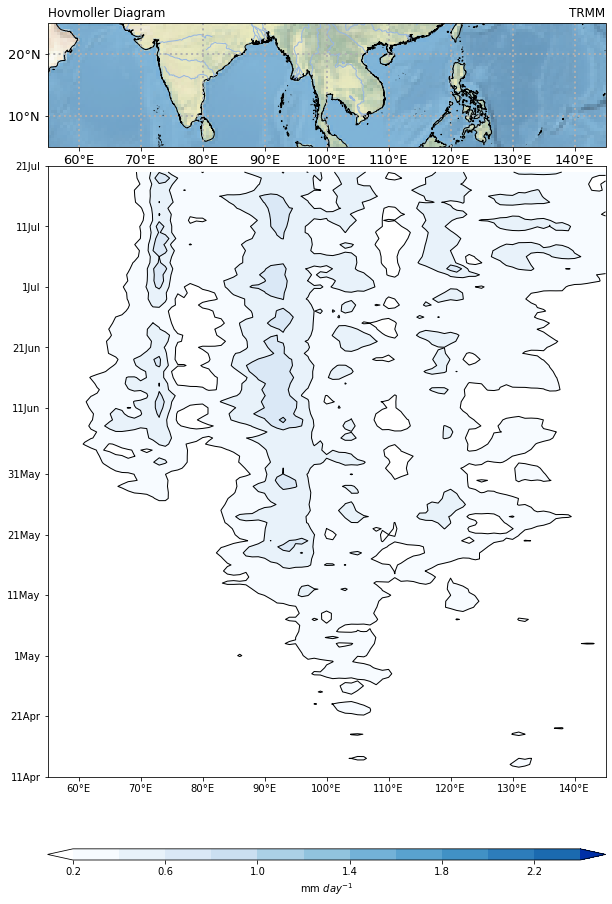

In [41]:
# Start figure
fig = plt.figure(figsize=(10, 17.5))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)


# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([55, 145, 5, 25], ccrs.PlateCarree())
ax1.set_yticks([10, 20])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'20\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(60,141,10))
ax1.set_xticklabels(x_tick_labels)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.05)
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES)
ax1.stock_img()

# Set some titles
plt.title('Hovmoller Diagram', loc='left')
plt.title('TRMM', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
cf   = ax2.contourf(prect_gpcp.lon.values, prect_gpcp.time.values, (prect_gpcp*weights3[None, :, None]).sum(dim='lat')/np.sum(weights3)/24, clevs, cmap=newcmp, extend='both')
cs   = ax2.contour(prect_gpcp.lon.values,  prect_gpcp.time.values, (prect_gpcp*weights3[None, :, None]).sum(dim='lat')/np.sum(weights3)/24, clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.09, aspect=50)
cbar.set_label('mm $day^{-1}$')

ax2.set_xticks(np.arange(60,141,10))
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(labelsize=10)

ax2.set_yticks(y_tick)
ax2.set_yticklabels(y_label)

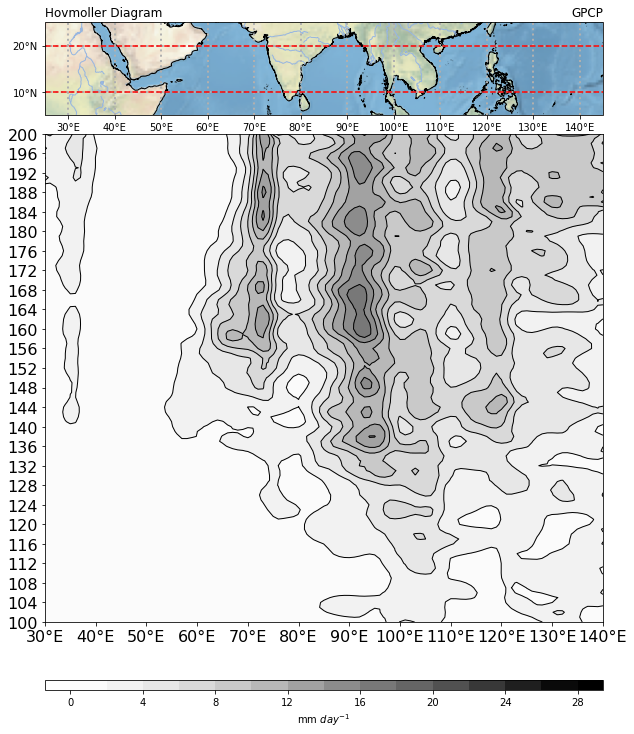

In [13]:
# Start figure
fig = plt.figure(figsize=(10, 14))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)

# Tick labels
x_tick_labels = []
for xx in range(30,150,10):
    x_tick_labels.append(u''+str(xx)+"\N{DEGREE SIGN}E")

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([25, 145, 5, 25], ccrs.PlateCarree())
ax1.set_yticks([10, 20])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'20\N{DEGREE SIGN}N'])
ax1.set_xticks(np.linspace(30,140,12))
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.05)
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES)
ax1.stock_img()

# 地图上加红线
ax1.plot([25,145],[10,10],color='red',linestyle='dashed')
ax1.plot([25,145],[20,20],color='red',linestyle='dashed')

# Set some titles
plt.title('Hovmoller Diagram', loc='left')
plt.title('GPCP', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
clevs = np.arange(0, 30, 2)
cf = ax2.contourf(prect3.lon.values, prect3.time.values, mpcalc.smooth_n_point(
    avg_prect3, 9, 2), clevs, cmap='Greys', extend='both')
cs = ax2.contour(prect3.lon.values, prect3.time.values, mpcalc.smooth_n_point(
    avg_prect3, 9, 2), clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.09, aspect=50, extendrect=True)
cbar.set_label('mm $day^{-1}$')

ax2.set_xticks(np.linspace(30,140,12))
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(labelsize=16)
ax2.set_yticks(np.linspace(100,200,26))

plt.show()

In [14]:
out_date(1981,100)

'0410'

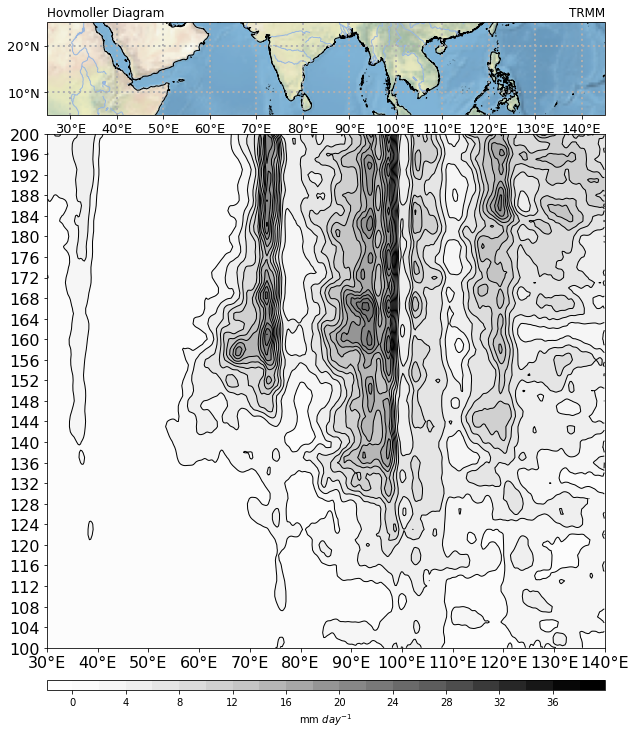

In [8]:
# Start figure
fig = plt.figure(figsize=(10, 14))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)

# Tick labels
x_tick_labels = []
for xx in range(30,150,10):
    x_tick_labels.append(u''+str(xx)+"\N{DEGREE SIGN}E")

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([25, 145, 5, 25], ccrs.PlateCarree())
ax1.set_yticks([10, 20])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'20\N{DEGREE SIGN}N'])
ax1.set_xticks(np.linspace(30,140,12))
ax1.set_xticklabels(x_tick_labels)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.05)
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES)
ax1.stock_img()

# Set some titles
plt.title('Hovmoller Diagram', loc='left')
plt.title('TRMM', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
clevs = np.arange(0, 40, 2)
cf = ax2.contourf(prect4.lon.values, prect4.time.values, mpcalc.smooth_n_point(
    avg_prect4, 9, 2), clevs, cmap='Greys', extend='both')
cs = ax2.contour(prect4.lon.values, prect4.time.values, mpcalc.smooth_n_point(
    avg_prect4, 9, 2), clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)
cbar.set_label('mm $day^{-1}$')

ax2.set_xticks(np.linspace(30,140,12))
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(labelsize=16)
ax2.set_yticks(np.linspace(100,200,26))


plt.show()